Alzheimer's detection from MRI imaging - Multimodal models & experiments



# Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
from google.colab import auth
auth.authenticate_user()
user = !gcloud config get-value account


import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import os
import skimage
from skimage.util import montage
from collections import defaultdict
import math
import random
import gc
import tensorflow as tf
import dask.array as da
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, Dropout, Input, Flatten, MaxPooling1D, MaxPooling2D, Softmax, concatenate
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import Sequential, Model
from tensorflow.keras.utils import plot_model

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Data

- Demographics table

- MRI images

In [ ]:
if user[0] == 'nickriina@gmail.com':
  demographics = pd.read_excel('/content/drive/MyDrive/Final Project Data/oasis_longitudinal_demographics.xlsx')
else:
  demographics = pd.read_excel('/content/drive/MyDrive/E533/final-project-data/oasis_longitudinal_demographics.xlsx')

In [14]:
demographics = pd.read_excel('/content/drive/MyDrive/E533/final-project-data/oasis_longitudinal_demographics.xlsx')

### Checking assumptions

For this code chunk below I take the demographic table, group by the patient and then count the number of unique MRIs and incidences of the group/CDR designation

In [14]:
# CDR isn't consistent across patients
demographics.groupby(
    ['Subject ID', 'CDR'])[['MRI ID']].agg('count').reset_index().groupby('Subject ID').filter(lambda x: len(x) != 1)

,Subject ID,CDR,MRI ID
3,OAS2_0005,0.0,2
4,OAS2_0005,0.5,1
5,OAS2_0007,0.5,1
6,OAS2_0007,1.0,2
12,OAS2_0014,0.5,1
...,...,...,...
172,OAS2_0176,0.5,1
176,OAS2_0181,0.5,1
177,OAS2_0181,1.0,2
180,OAS2_0184,0.5,1


In [4]:
# Group is consistent across patients
demographics.groupby(
    ['Subject ID', 'Group'])[['MRI ID']].agg('count').reset_index().groupby('Subject ID').filter(lambda x: len(x) != 1)

,Subject ID,Group,MRI ID


## Split

In [15]:
# get patients and MRIs that we're using for training/validation (i.e. not converted patients)
dem = demographics[demographics.Group != 'Converted'][['co','MRI ID']].groupby(['co']).agg(list).reset_index()
pt_dict = dict(zip(dem['co'], dem['MRI ID']))

In [16]:
# get patients and MRIs that are part of the converted group
conv = demographics[demographics.Group == 'Converted'].groupby(['co']).agg(list).reset_index()
conv_dict = dict(zip(conv['co'], conv['MRI ID']))

In [7]:
# pt_dict.keys()
pt_dict['OAS2_0001']

['OAS2_0001_MR1', 'OAS2_0001_MR2']

In [17]:
def split_mris(patients_dict, train_prop = 0.9):
  random.seed(123)
  pts_list = list(patients_dict.keys())
  n_pts = len(pts_list)
  n_pts_train = math.floor(n_pts * train_prop)
  pts_train = random.sample(pts_list, n_pts_train)
  train_mris = [i for x in pts_train for i in patients_dict[x]]
  test_mris = [i for x in pts_list for i in patients_dict[x] if x not in pts_train]
  return train_mris, test_mris

In [20]:
def make_split_dict(keys = ['images','group','cdr','MR_Delay','M/F','Hand','Age','EDUC','SES','MMSE','nWBV','ASF']):
  d = {}
  for k in keys:
    d[k] = []
  return d

In [21]:
def load_imgs(mri, out_dict, user_name = user[0]):
  if user_name == 'LELee2000@gmail.com':
    base = '/content/drive/MyDrive/E533/final-project-data/MRI_Data/' 
  else:
    base = '/content/drive/MyDrive/Final Project Data/MRI_Data/'
  dir = base + mri + '/RAW'
  info = demographics[demographics['MRI ID'] == mri]
  dem_non = lambda x: 0 if x == 'Nondemented' else 1
  g = info.Group.item()
  g = dem_non(g)
  cdr = info.CDR.item()
  mrdel = info['MR Delay'].item()
  gender = info['M/F'].item()
  code_malefem = lambda x: 0 if x == 'F' else 1
  gender = code_malefem(gender)
  hand = info['Hand'].item()
  code_rightleft = lambda x: 0 if x == 'L' else 1
  hand = code_rightleft(hand)
  age = info['Age'].item()
  educ = info['EDUC'].item()
  ses = info['SES'].item()
  mmse = info['MMSE'].item()
  nwbv = info['nWBV'].item()
  asf = info['ASF'].item()
  
  for img in os.listdir(dir):
    try:
      if img.endswith('.img'):
        f = dir + '/' + img
        img = nib.load(f)
        o = img.dataobj
        o = np.asarray(o)
        # o = tf.squeeze(o)
        # i = a.reshape(128,256,256)
        out_dict['images'].append(o)
        img.uncache()
        out_dict['group'].append(g)
        out_dict['cdr'].append(cdr)
        out_dict['MR_Delay'].append(mrdel)
        out_dict['M/F'].append(gender)
        out_dict['Hand'].append(hand)
        out_dict['Age'].append(age)
        out_dict['EDUC'].append(educ)
        out_dict['SES'].append(ses)
        out_dict['MMSE'].append(mmse)
        out_dict['nWBV'].append(nwbv)
        out_dict['ASF'].append(asf)
          

    except FileNotFoundError:
      pass

In [23]:
def split_imgs_dem(data):
  dem_info = [np.array([data[x][i] for x in data.keys() if x != 'group' and x != 'cdr' and x!= 'images' and x!= 'Hand']) for i in range(len(data['images']))]
  images = [data['images'][i] for i in range(len(data['images']))]
  group_info = [data['group'][i] for i in range(len(data['images']))]
  return images, dem_info, group_info

In [9]:
def split_patients(pt_dict = pt_dict, train_prop = .9, user_name = user[0]):
  if user_name == 'LELee2000@gmail.com':
    base = '/content/drive/MyDrive/E533/final-project-data/MRI_Data/' 
  else:
    base = '/content/drive/MyDrive/Final Project Data/MRI_Data/'
  # + mri_id + '/RAW'
  tr_mri, te_mri = split_mris(pt_dict, train_prop = train_prop)
  train = make_split_dict()
  test = make_split_dict()

  for mri in tr_mri:
    load_imgs(mri, train)


  for mri in te_mri:
    load_imgs(mri, test)


  return train, test

In [ ]:
tr, te = split_patients(train_prop = 0.9)

In [ ]:
train_x1, train_x2, train_y = split_imgs_dem(tr)
test_x1, test_x2, test_y = split_imgs_dem(te)

In [ ]:
train_x2 = np.array(train_x2)
train_y = np.array(train_y)
test_x2 = np.array(test_x2)
test_y = np.array(test_y)
train_x1 = np.asarray(train_x1)
test_x1 = np.asarray(test_x1)

In [34]:
converted = make_split_dict()
cmri_x, cmri = split_mris(conv_dict, 0.2)
for mri in cmri:
    load_imgs(mri, converted)

c_x1, c_x2, c_y = split_imgs_dem(converted)
c_x1 = np.array(c_x1)
c_x2 = np.array(c_x2)
c_y = np.ones(c_y.shape)

### Images

In [16]:
def reshape_nib(img):
  reshaped = [img[:,:,i] for i in range(128)]
  squeezed = tf.squeeze(reshaped)
  return squeezed

In [ ]:
plt.figure(figsize=(15,15))
img = reshape_nib(tr['images'][0])
plt.imshow(montage(img))
plt.title('MRI Example')
plt.xticks([])
plt.yticks([])

## Models (initial construction)

In [ ]:
class MyModel(tf.keras.Model):

  def __init__(self, demographic_dim = 10): #demographic dim is the dim of all inputs that arent pic
    super().__init__()
    self.picinput = Input(shape=(256,256,128))
    self.conv1 = Conv2D(filters=128, 
                        kernel_size=3, 
                        strides=(2, 2), 
                        activation='relu',
                        kernel_initializer=HeNormal,
                        data_format="channels_last")(self.picinput)
    self.conv2 = Conv2D(filters=64, 
                        kernel_size=3, 
                        strides=(2, 2), 
                        activation='relu')(self.conv1)
    self.maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(self.conv2)
    self.picflat = Flatten()(self.maxpool1)

    self.otherinput = Input(shape=(demographic_dim,))
    self.combinedinput = tf.keras.layers.concatenate([self.picflat,self.otherinput])
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)(self.combinedinput)
    self.dense2 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(self.dense1)

    self.model = Model(inputs=[self.picinput,self.otherinput],outputs=self.dense2)

  def call(self, inputs):
    # x = self.model(inputs)
    return self.model(inputs)

model = MyModel()


In [ ]:
#example with input:
img1 = tf.squeeze(tr['images'][0:10])
dem1 = tf.squeeze(tf.expand_dims(np.random.random((10,10)), axis=0))
print(np.shape(img1))
print(np.shape(dem1))

(10, 256, 256, 128)
(10, 10)


In [ ]:
pred = model.model([img1,dem1]) #in this way, the pics and images need to be separate tensors so we can do convolutional only on image

In [ ]:
np.shape(pred) #it works!

TensorShape([10, 1])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy'])

In [ ]:
model.fit([img1,dem1],np.ones(10),epochs=5)

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 3.9038 - accuracy: 0.8000
Epoch 2/5
1/1 [==============================] - 0s 162ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 0s 195ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 0s 193ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 146ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [ ]:
pred = model.model([img1,dem1])
pred

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>

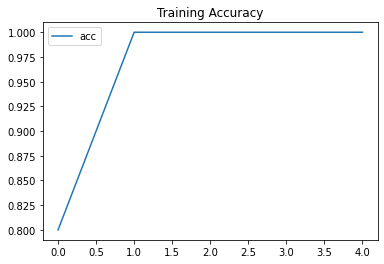

In [ ]:
conv_acc = model.history.history['accuracy']
conv_err = model.history.history['loss']
# model4_trainacc = model4_hist.history['accuracy']
# np.save("model2_acc",model2_acc)
# model2_acc = np.load("model2_acc.npy")
plt.figure()
plt.title("Training Accuracy")
plt.plot(conv_acc,label='acc')
# plt.plot(model4_trainacc,label='Transfer Learning')
plt.legend()

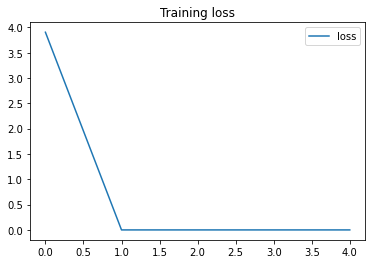

In [ ]:
plt.figure()
plt.title("Training loss")
plt.plot(conv_err,label='loss')
plt.legend()

## More modeling

Things to note:

- Training/test split -- we need to think through splitting by PATIENT vs randomly splitting MRI recordings since two MRI recordings from the same patient are technically *not* independent

- Sample size

- Use/intake/imputation of demographic data

In [5]:
demographic_dim = 8
picinput = Input(shape=(256,256,128), name = 'Image_Input')
conv1 = Conv2D(filters=128, 
                    kernel_size=3, 
                    strides=(2, 2), 
                    activation='relu',
                    kernel_initializer=HeNormal,
                    data_format="channels_last", name = 'Conv2D_1')(picinput)
conv2 = Conv2D(filters=64, 
                    kernel_size=3, 
                    strides=(2, 2), 
                    activation='relu', name = 'Conv2D_2')(conv1)
maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', name = 'MaxPool2D_1')(conv2)
picflat = Flatten(name = 'FlattenImage')(maxpool1)

otherinput = Input(shape=(demographic_dim,), name = 'Demographics_Input')
combinedinput = tf.keras.layers.concatenate([picflat,otherinput], name = 'Combine_Img_Demographics')
dense1 = Dense(4, activation='relu', name = 'Dense1')(combinedinput)
dense2 = Dense(1, activation='sigmoid', name = 'Dense2')(dense1)

model = Model(inputs=[picinput,otherinput],outputs=dense2)

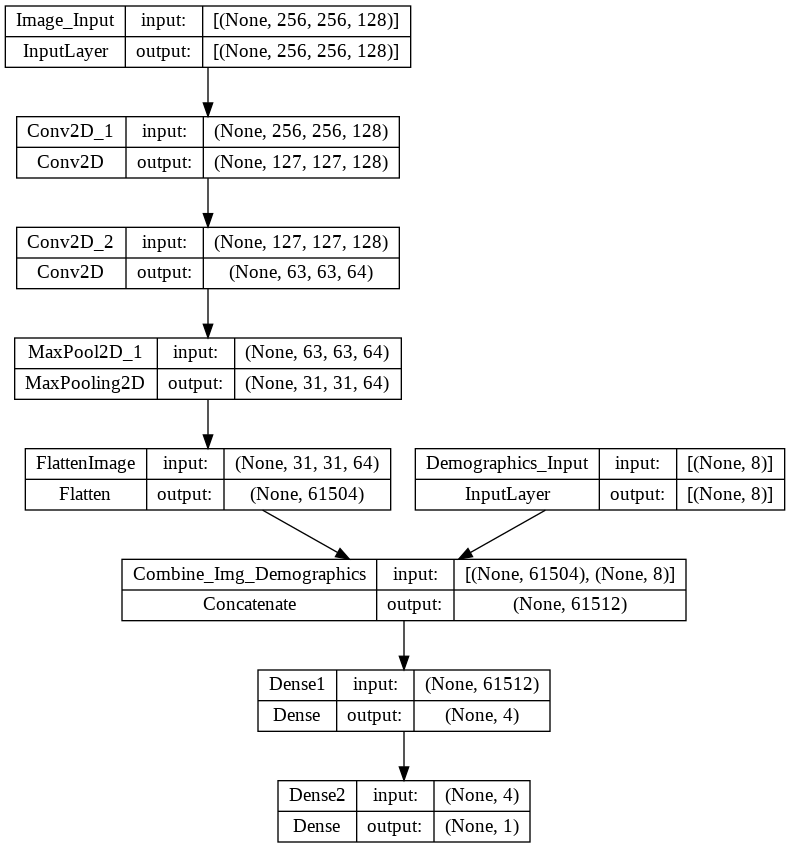

In [6]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [9]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy'])

In [ ]:
history = model.fit([train_x1, train_x2], train_y, epochs = 75, validation_data = ([test_x1, test_x2], test_y))

In [ ]:
model.evaluate([c_x1, c_x2], c_y)

### Model 2

In [32]:
picinput = Input(shape=(256,256,128), name = 'Image_Input')
conv1 = Conv2D(filters=128, 
                    kernel_size=3, 
                    strides=(2, 2), 
                    activation='relu',
                    kernel_initializer=HeNormal,
                    data_format="channels_last", name = 'Conv2D_1')(picinput)
conv2 = Conv2D(filters=64, 
                    kernel_size=3, 
                    strides=(2, 2), 
                    activation='relu', name = 'Conv2D_2')(conv1)
maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', name = 'MaxPool2D_1')(conv2)
picflat = Flatten(name = 'FlattenImage')(maxpool1)

# otherinput = Input(shape=(demographic_dim,), name = 'Demographics_Input')
# combinedinput = tf.keras.layers.concatenate([picflat,otherinput], name = 'Combine_Img_Demographics')
dense1 = tf.keras.layers.Dense(4, activation='relu', name = 'Dense1')(picflat)
dense2 = tf.keras.layers.Dense(1, activation='sigmoid', name = 'Dense2')(dense1)

model2 = Model(inputs=[picinput,otherinput],outputs=dense2)

In [33]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy'])

In [ ]:
model2.fit([train_x1, train_x2], train_y, epochs = 75, validation_data = ([test_x1, test_x2], test_y))

In [ ]:
model2.evaluate([c_x1, c_x2], c_y)

https://iu.zoom.us/j/85818994266